# Data Evaluation for Multi-Grasp motion planner

In [1]:
# Common imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

## Profiling
This section contains code to load, average and visualize profiling results.

In [2]:
    def load_stats(filename):
        """Load profiling stats for an algorithm from the given file.
        Args:
            filename, string: name of the stats file.
        Returns:
            pd.DataFrame: Profiling stats with standard deviations
        """
        run_stats = pd.read_csv(filename)
        avg_run_stats = run_stats.groupby('function_name').mean()
        time_columns = ['total_runtime', 'avg_runtime', 'total_cpu_time', 'avg_cpu_time']
        time_columns_std = [name + "_std" for name in time_columns]
        avg_run_stats[time_columns_std] = run_stats.groupby('function_name').std()[time_columns]
        return avg_run_stats

Show the profiling stats of a specific algorithm:

In [3]:
load_stats('/home/joshua/projects/placement_catkin/experiment_results/tests/trial2/LazySP_LWLPAstar__LazyGrownLazyEdgeWeightedMultiGraspGraph__cluttered_field_const__30-grasps__0.5-step_size__1000-batch_size/run_stats')

,num_calls,total_runtime,avg_runtime,total_cpu_time,avg_cpu_time,total_runtime_std,avg_runtime_std,total_cpu_time_std,avg_cpu_time_std
function_name,,,,,,,,,
IntegralEdgeCostComputer::lowerBound,15766,0.005991,3.799760e-07,0.006568,4.165930e-07,NaN,NaN,NaN,NaN
LPAStarAlgorithm::computeShortestPath,15,1.262050,8.413680e-02,1.253910,8.359390e-02,NaN,NaN,NaN,NaN
LPAStarAlgorithm::updateEdges,15,0.000078,5.228670e-06,0.000082,5.466670e-06,NaN,NaN,NaN,NaN
LazyLayeredMultiGraspRoadmapGraph::checkValidity,7346,0.017225,2.344820e-06,0.017609,2.397090e-06,NaN,NaN,NaN,NaN
LazyLayeredMultiGraspRoadmapGraph::getBestGoal,5246,0.002781,5.301500e-07,0.002998,5.714830e-07,NaN,NaN,NaN,NaN
LazyLayeredMultiGraspRoadmapGraph::getEdgeCost,57604,0.094061,1.632900e-06,0.096037,1.667190e-06,NaN,NaN,NaN,NaN
LazyLayeredMultiGraspRoadmapGraph::getGraspRoadmapId,21,0.000009,4.238100e-07,0.000008,3.809520e-07,NaN,NaN,NaN,NaN
LazyLayeredMultiGraspRoadmapGraph::getGraspSpecificEdgeCost,88,0.014387,1.634880e-04,0.014340,1.629550e-04,NaN,NaN,NaN,NaN
LazyLayeredMultiGraspRoadmapGraph::getNewEdges,15,0.000008,5.313330e-07,0.000010,6.666670e-07,NaN,NaN,NaN,NaN


## Loading summarized results
This section contains code to load summarized results, i.e. number of evaluated nodes, runtime, number of evaluated edges, ...

In [136]:
algo_to_function = {
    "LazySP_LWLPAstar_LazyGrown": 'lazySPLazyLayered',
    "LazySP_LLPAstar_LazyGrown": 'lazySPLazyLayered',
    "LazySP_LWLPAstar": 'lazySP',
    "LazySP_LLPAstar": 'lazySP',
    "LazySP_LPAstar": 'lazySP',
    "LWAstar": "lwaStarSearch",
    "LWLPAstar": "lpaStarSearch",
    "LPAstar": "lpaStarSearch",
    "Astar": "aStarSearch",
    # TODO add other algorithm to function mappings here
}

def get_function_name(algo, graph):
    if 'LazyGrown' in graph:
        return algo_to_function[algo + '_LazyGrown']
    else:
        return algo_to_function[algo]


def count_event(log_line, storage):
    """ Count a roadmap evalation log event.
    Args:
        log_line, str - a line from a log file.
        storage, dict - dictionary to update counts in.
            Needs to have keys 'base_validity', 'grasp_validity', 'base_cost', 'grasp_cost', 'base_expansions'. 'grasp_expansions'
    """
    line_args = log_line.split(',')
    storage['base_validity'] += line_args[0] == "VAL_BASE"
    storage['grasp_validity'] += line_args[0] == "VAL_GRASP"
    storage['base_cost'] += line_args[0] == "EDGE_COST"
    storage['grasp_cost'] += line_args[0] == "EDGE_COST_GRASP"
    storage['base_expansions'] += line_args[0] == "BASE_EXPANSION"
    storage['grasp_expansions'] += line_args[0] == "EXPANSION"

def toTestCaseId(scene_name, num_grasps, step_size, batch_size):
    return scene_name + '__' + str(num_grasps) + '__' + str(step_size) + '__' + str(batch_size)

def load_test_case_result(result_folder, runtime_type='total_runtime'):
    """Load the result of a single test case and return it as a pandas.Series.
    Args:
        result_folder, string: The folder containing the results of the test case.
            The folder should contain four files 'log_evaluation', 'log_roadmap', 'run_stats' and 'results' produced
            by testing the MGSearchMotionPlanner. The name of the result folder should follow the format
            <algo_name>__<graph_name>__<scene_name>__<num_grasps>
    """
    folder_name = os.path.basename(os.path.normpath(result_folder))
    algo_name, graph_name, scene_name, grasp_str, step_str, batch_str = folder_name.split('__')
    num_grasps = int(grasp_str.split('-')[0])
    step_size = float(step_str.split('-')[0])
    batch_size = int(batch_str.split('-')[0])
    # load runtime statistics
    avg_run_stats = load_stats(result_folder + '/run_stats')
    # read number of roadmap nodes
    with open(result_folder + '/log_roadmap', 'r') as roadmap_file:
        num_nodes = len(roadmap_file.readlines())
    # read number of validity checks, edge evaluations and expansions
    roadmap_evaluations = {'base_validity': 0, 'grasp_validity': 0, 'base_cost': 0, 'grasp_cost': 0, 'base_expansions': 0, 'grasp_expansions': 0}
    with open(result_folder + '/log_evaluation', 'r') as evalulation_file:
        for line in evalulation_file:
            count_event(line, roadmap_evaluations)
    # read planning results
    planning_results = pd.read_csv(result_folder + '/results')
    # perform sanity checks
    uniqueness = planning_results.nunique()
    if uniqueness[uniqueness != 1].size > 0:
        raise ValueError("ERROR: The results in folder %s are inconsistent:\n %s" % (result_folder, str(planning_results)))
    # Create Series for this test case
    return pd.Series({'algorithm': algo_name, 
                      'graph': graph_name, 
                      'runtime': avg_run_stats.loc[get_function_name(algo_name, graph_name), runtime_type],
                      'runtime_std': avg_run_stats.loc[get_function_name(algo_name, graph_name), runtime_type + '_std'], 
                      'base_validity_checks': roadmap_evaluations['base_validity'],
                      'grasp_validity_checks': roadmap_evaluations['grasp_validity'],
                      'base_edge_cost': roadmap_evaluations['base_cost'],
                      'grasp_edge_cost': roadmap_evaluations['grasp_cost'],
                      'base_expansions': roadmap_evaluations['base_expansions'],
                      'grasp_expansions': roadmap_evaluations['grasp_expansions'],
                      'roadmap_size': num_nodes,
                      'scene': scene_name, 
                      'num_grasps': num_grasps,
                      'step_size': step_size,
                      'cost': planning_results['cost'].iloc[0],
                      'goal_id': planning_results['goal_id'].iloc[0],
                      'test_case_id': toTestCaseId(scene_name, num_grasps, step_size, batch_size)})

def load_results(results_base_folder):
    """Load all results in the given base folder and return in a single DataFrame.
    Args:
        results_base_folder, str: Path to the folder containing various result sub-folders.
    Returns:
        pd.DataFrame: Data frame containing all results.
    """
    series = []
    for fname in os.listdir(results_base_folder):
        series.append(load_test_case_result(results_base_folder + '/' + fname))
    return pd.DataFrame(series)

In [137]:
data = load_results('/home/joshua/projects/placement_catkin/experiment_results/paper/2d/')
data.sort_values(['scene', 'algorithm'])
# pr = pd.read_csv('/tmp/test/LazySP_LWLPAstar__LazyWeightedMultiGraspGraph__Bugtrap2DScene__4/results')
# pr['cost'].iloc[0]

,algorithm,graph,runtime,runtime_std,base_validity_checks,grasp_validity_checks,base_edge_cost,grasp_edge_cost,base_expansions,grasp_expansions,roadmap_size,scene,num_grasps,step_size,cost,goal_id,test_case_id
35,LWAstar,SingleGraspGraph,3.875150,NaN,2803,8528,0,8516,0,7203,5025,cluttered_field_const,8,0.1,2009.98,4,cluttered_field_const__8__0.1__5000-batch_size
73,LWAstar,MultiGraspGraph,0.172735,NaN,520,1497,0,1731,1,1212,1025,cluttered_field_const,8,2.5,2050.39,13,cluttered_field_const__8__2.5__1000-batch_size
106,LWAstar,MultiGraspGraph,2.691260,NaN,2054,19774,0,19110,1,16711,5091,cluttered_field_const,30,2.5,1981.47,34,cluttered_field_const__30__2.5__5000-batch_size
112,LWAstar,MultiGraspGraph,9.825380,NaN,2102,20354,0,19984,1,17202,5091,cluttered_field_const,30,0.1,1990.08,34,cluttered_field_const__30__0.1__5000-batch_size
114,LWAstar,SingleGraspGraph,0.352189,NaN,697,3419,0,3974,0,2751,1049,cluttered_field_const,16,2.5,2021.87,34,cluttered_field_const__16__2.5__1000-batch_size
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2123,LazySP_LWLPAstar,LazyGrownLazyWeightedMultiGraspGraph,1.096710,NaN,3667,90,5468,0,6737,0,5091,cluttered_field_infeasible_dist,30,2.5,inf,0,cluttered_field_infeasible_dist__30__2.5__5000...
2138,LazySP_LWLPAstar,LazyEdgeWeightedMultiGraspGraph,11.871900,NaN,6526,80695,11940,0,1,112938,10091,cluttered_field_infeasible_dist,30,0.5,inf,0,cluttered_field_infeasible_dist__30__0.5__1000...
2143,LazySP_LWLPAstar,LazyGrownLazyEdgeWeightedMultiGraspGraph,4.870040,NaN,6726,90,12666,0,15827,0,10091,cluttered_field_infeasible_dist,30,0.1,inf,0,cluttered_field_infeasible_dist__30__0.1__1000...
2155,LazySP_LWLPAstar,LazyGrownLazyWeightedMultiGraspGraph,1.568170,NaN,3625,48,5470,0,6953,0,5049,cluttered_field_infeasible_dist,16,0.5,inf,0,cluttered_field_infeasible_dist__16__0.5__5000...


In [13]:
data.to_csv('/home/joshua/projects/placement_catkin/experiment_results/paper/2d.csv')

In [2]:
data = pd.read_csv('/home/joshua/projects/placement_catkin/experiment_results/paper/2d.csv')

In [173]:
# data_annotated = data.assign(test_case=data['scene'] + '__' + data['num_grasps'].astype(str) + '__' + data['step_size'].astype(str) + '__' + data['roadmap_size'].astype(str))
# grouped = data_annotated.groupby('test_case')
# list(grouped.groups.keys())
# data['test_case_id'] = data['test_case_id'].str.replace('-batch_size', '')
data[data['algorithm'] == 'LWAstar'].sort_values(['test_case_id'])

,Unnamed: 0,Unnamed: 0.1,algorithm,graph,runtime,runtime_std,base_validity_checks,grasp_validity_checks,base_edge_cost,grasp_edge_cost,base_expansions,grasp_expansions,roadmap_size,scene,num_grasps,step_size,cost,goal_id,test_case_id
614,614,614,LWAstar,MultiGraspGraph,2.028080,NaN,529,2481,0,2894,1,1983,1049,cluttered_field_const,16,0.1,2025.33,34,cluttered_field_const__16__0.1__1000
1485,1485,1485,LWAstar,SingleGraspGraph,2.749410,NaN,697,3427,0,4089,0,2753,1049,cluttered_field_const,16,0.1,2025.33,34,cluttered_field_const__16__0.1__1000
2091,2091,2091,LWAstar,SingleGraspGraph,12.209200,NaN,5106,30629,0,28452,0,25742,10049,cluttered_field_const,16,0.1,1981.09,34,cluttered_field_const__16__0.1__10000
2118,2118,2118,LWAstar,MultiGraspGraph,9.336930,NaN,3503,20688,0,19250,1,17599,10049,cluttered_field_const,16,0.1,1981.09,34,cluttered_field_const__16__0.1__10000
1187,1187,1187,LWAstar,MultiGraspGraph,5.183610,NaN,1954,10680,0,10571,1,8993,5049,cluttered_field_const,16,0.1,1990.08,34,cluttered_field_const__16__0.1__5000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
766,766,766,LWAstar,MultiGraspGraph,0.360681,NaN,753,2361,0,5115,1,1898,1025,cluttered_field_infeasible_dist,8,2.5,inf,0,cluttered_field_infeasible_dist__8__2.5__1000
1224,1224,1224,LWAstar,SingleGraspGraph,5.329740,NaN,6169,24030,0,79541,0,20018,10025,cluttered_field_infeasible_dist,8,2.5,inf,0,cluttered_field_infeasible_dist__8__2.5__10000
1636,1636,1636,LWAstar,MultiGraspGraph,5.656600,NaN,6169,24030,0,79541,1,20018,10025,cluttered_field_infeasible_dist,8,2.5,inf,0,cluttered_field_infeasible_dist__8__2.5__10000
2024,2024,2024,LWAstar,SingleGraspGraph,2.124350,NaN,3367,12084,0,34323,0,10017,5025,cluttered_field_infeasible_dist,8,2.5,inf,0,cluttered_field_infeasible_dist__8__2.5__5000


In [156]:
def verify_results(data):
    """ Check that in the given data all algorithms agree on the same cost for each test cases
        and that all test cases are complete. 
    """
    grouped = data.groupby('test_case_id')
    if (grouped['cost'].aggregate('std') > 0.0).any():
        return False
    if (grouped['goal_id'].aggregate('std') > 0.0).any():
        return False
    return len(data) / len(grouped.groups) == list(grouped.groups.values())[0].shape[0]

verify_results(data)

True

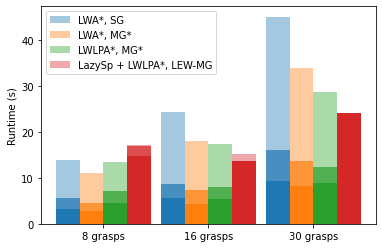

In [121]:
from matplotlib import cm

pretty_algo_names = {
    'LWAstar': 'LWA*',
    'LWLPAstar': 'LWLPA*',
    'LazySP_LWLPAstar': 'LazySp + LWLPA*',
}

pretty_graph_names = {
    'SingleGraspGraph': 'SG',
    'MultiGraspGraph': 'MG*',
    'LazyGrownLazyEdgeWeightedMultiGraspGraph': 'LG-LEW-MG',
    'LazyEdgeWeightedMultiGraspGraph': 'LEW-MG',
}

def prettify(algo_graph):
    # return str(algo_graph)
    # return algo_graph
    return pretty_algo_names[algo_graph[0]] + ', ' + pretty_graph_names[algo_graph[1]]

# test_case = 'cluttered_field_dist_adv__8__0.1__1000'
# inputs
scene = 'cluttered_field_dist'
roadmap_size = 10000
algo_graph_combos = [('LWAstar', 'SingleGraspGraph'), ('LWAstar', 'MultiGraspGraph'), ('LWLPAstar','MultiGraspGraph'),('LazySP_LWLPAstar', 'LazyEdgeWeightedMultiGraspGraph')] # operations
bar_gap = 0.1  # percentage of space that the gap between groups should take
# data[["algorithm", "graph"]]
scene_data = data[(data['scene'] == scene) & (data['roadmap_size'] < roadmap_size + 100) & (data['roadmap_size'] >= roadmap_size)]
plot_data = scene_data.pivot(index=['step_size', 'num_grasps'],columns=['algorithm', 'graph'], values='runtime')
# plot_data
# plot_data[algo_graph_combos].plot(kind='bar', title='test')
# plot_data
step_sizes = list(scene_data['step_size'].unique())
step_sizes.sort()
# step_sizes = [step_sizes[2]]
num_grasps = scene_data['num_grasps'].unique()

x = np.arange(len(num_grasps))
bar_width = (1.0 - bar_gap) / len(algo_graph_combos)
rel_bar_centers = np.linspace(bar_gap/2.0, 1.0 - bar_gap/2.0, len(algo_graph_combos), endpoint=False) + bar_width / 2.0 - 0.5

fig, ax = plt.subplots()
bars = []
for sidx, step_size in enumerate(step_sizes):
    for idx, algo_graph in enumerate(algo_graph_combos):
        # color = (1 + float(sidx)/len(step_sizes)) * np.array(cm.tab10.colors[idx])
        color = cm.tab10.colors[idx]
        alpha = min(1.0, 0.9 * float(sidx+1) / len(step_sizes) + 0.1)
        # color = [color[0], color[1], color[2], 1.0 - 0.5 * float(sidx) / len(step_sizes)]
        # print(alpha, step_size)
        bars.append(ax.bar(x + rel_bar_centers[idx], plot_data.loc[step_size][algo_graph], bar_width, color=color, alpha=alpha))

ax.set_ylabel('Runtime (s)')
ax.set_xticks(x)
ax.set_xticklabels(map(lambda x: str(x) + ' grasps', plot_data.loc[step_sizes[0]].index.values))
ax.legend(bars[:len(algo_graph_combos)], map(prettify, algo_graph_combos))
# step_sizes

# pd.__version__
# keys = data['algorithm'].astype(str) + '__' + data['graph'].astype(str)
# new_data = pd.DataFrame(data[['runtime', 'num_grasps']]) #, index=keys)
# new_data
# idx = pd.MultiIndex.from_frame(data[["algorithm", "graph"]])
# idx
# data['runtime']
# tmp_data = pd.DataFrame(data[['test_case_id']], index=)
# tmp_data
# plot_data = data[(data['test_case_id'] == test_case) & ((data['algorithm'].astype(str) + '__' + data['graph'].astype(str)).isin(algo_graph_combos))]
# plot_data = plot_data.pivot(index='algorithm', columns='graph', values='runtime')
# plot_data = plot_data.fillna(0)
# plot_data.fillna(0)

In [69]:
scene = 'cluttered_field_dist'
roadmap_size = 1000
algo_graph_combos = [('LWAstar', 'SingleGraspGraph'), ('LWAstar', 'MultiGraspGraph'), ('LWLPAstar','MultiGraspGraph'),('LazySP_LWLPAstar', 'LazyGrownLazyEdgeWeightedMultiGraspGraph')] # operations
bar_gap = 0.1  # percentage of space that the gap between groups should take
# data[["algorithm", "graph"]]
scene_data = data[(data['scene'] == scene) & (data['roadmap_size'] < roadmap_size + 100)]
plot_data = scene_data.pivot(index=['step_size', 'num_grasps'],columns=['algorithm', 'graph'], values='runtime')
# plot_data.loc[0.1][algo_graph_combos[0]]


OrderedDict()

In [165]:
# def create_runtime_bar_plot(scene, roadmap_size, algo_graph_combos, data):

def plot_runtimes(data, test_case, algo_graph_combos):
    plot_data = data[(data['test_case_id'] == test_case) & ((data['algorithm'].astype(str) + '__' + data['graph'].astype(str)).isin(algo_graph_combos))]
    plot_data = plot_data.pivot(index='algorithm', columns='graph', values='runtime')
    plot_data = plot_data.fillna(0)
    plot_data['MultiGraspGraph'] = (plot_data['MultiGraspGraph'] + plot_data['LazyEdgeWeightedMultiGraspGraph']).astype("float")
    return plot_data[['SingleGraspGraph', 'MultiGraspGraph']].plot(kind='bar', title=test_case)
# pd.DataFrame(bugtrap_data[bugtrap_data['graph'] == 'SingleGraspGraph']['runtime'], columns=bugtrap_data[bugtrap_data['graph'] == 'SingleGraspGraph']['algorithm'])
# plot = plot_runtimes(data, 'Bugtrap2DScene', ['Astar', 'LWAstar', 'LazySP_LWLPAstar'])
# plot = plot_runtimes(data, 'Standard2DScene', ['Astar', 'LWAstar', 'LazySP_LWLPAstar'])
# plot = plot_runtimes(data, 'YumiTestScene6grasps', ['LWAstar', 'LazySP_LWLPAstar'])
# plot = plot_runtimes(data, 'YumiTestScene20grasps', ['LWAstar', 'LazySP_LWLPAstar'])
# plot = plot_runtimes(data, 'YumiTestScene158grasps', ['LWAstar', 'LazySP_LWLPAstar'])
plot = plot_runtimes(data, 'cluttered_field_dist_adv__8__0.1__1000', ['LWAstar', 'LWLPAstar'])
#ax = plot.gca()
plot.tick_params(axis='x', labelrotation=45)
fig = plot.get_figure()
fig.savefig('/tmp/test.png', bbox_inches='tight')



KeyError: 'LazyEdgeWeightedMultiGraspGraph'

In [7]:
# read all results in a folder
load_results('/tmp/placement_eval')


,algorithm,graph,runtime,runtime_std,base_validity_checks,grasp_validity_checks,base_edge_cost,grasp_edge_cost,base_expansions,grasp_expansions,roadmap_size,scene,num_grasps
0,LWAstar,SingleGraspGraph,0.438916,0.021709,623,710,0,589,0,514,10006,Standard2DScene,2
1,LWAstar,FoldedMultiGraspGraphDynamic,0.818320,0.063116,892,408,673,395,651,378,10006,Standard2DScene,2
2,LWAstar,FoldedMultiGraspGraphDynamic,0.109444,0.002362,102,102,12,2,3,2,1101,YumiTestScene,6
3,LWAstar,MultiGraspGraph,0.372321,0.045744,505,610,0,451,1,416,10006,Standard2DScene,2
4,LWAstar,SingleGraspGraph,282.793000,4.598705,1101,2454,0,11884,0,2116,1101,YumiTestScene,6
5,LWAstar,FoldedMultiGraspGraphStationary,1.461936,0.047954,1833,1038,673,967,651,926,10006,Standard2DScene,2
6,LWAstar,MultiGraspGraph,0.194319,0.002220,102,103,0,12,1,3,1101,YumiTestScene,6
7,LazySP_LWLPAstar,LazyWeightedMultiGraspGraph,4.060318,0.082785,584,80,555,64,1,33781,10006,Standard2DScene,2
8,LazySP_LWLPAstar,LazyWeightedMultiGraspGraph,0.239866,0.007013,102,102,12,2,1,15,1101,YumiTestScene,6
9,LWAstar,FoldedMultiGraspGraphStationary,0.122753,0.000987,102,102,12,3,3,3,1101,YumiTestScene,6


## Plotting results
This section defines some functions to plot results.